In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import apply_cats, proc_df
from fastai.column_data import *
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import dill as pickle
from IPython.display import display

pd.options.display.max_columns = None
import numpy as np
np.set_printoptions(threshold=50, edgeitems=20)
data_path=Path('data/')
PATH = data_path
SK_ID_CURR = "SK_ID_CURR"

In [3]:
cred_card_bal = pickle.load(open('data/credit_card_balance','rb'))
pos_cash_bal = pickle.load(open('data/POS_CASH_balance','rb'))
prev = pickle.load(open('data/previous_application','rb'))
bureau_bal = pickle.load(open('data/bureau_balance','rb'))
install = pickle.load(open('data/installments_payments','rb'))
bureau = pickle.load(open('data/bureau','rb'))
application_train = pickle.load(open('data/application_train','rb'))
application_test = pickle.load(open('data/application_test','rb'))

In [4]:
merged_df = pickle.load(open('data/merged_df.pickle','rb'))

In [5]:
len(merged_df.columns)

213

In [6]:
prev.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1327623,1964938,156309,Cash loans,16279.335,463500.0,536917.5,NaN,463500.0,SATURDAY,8,Y,1,NaN,NaN,NaN,XNA,Refused,-397,Cash through the bank,HC,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,48.0,low_action,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
1145379,2176617,127659,Cash loans,40119.390,855000.0,954315.0,NaN,855000.0,MONDAY,6,Y,1,NaN,NaN,NaN,Everyday expenses,Refused,-543,Cash through the bank,VERIF,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,48.0,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
592644,1525697,319126,Consumer loans,NaN,66522.6,66522.6,0.0,66522.6,THURSDAY,11,Y,1,0.000000,NaN,NaN,XAP,Refused,-722,Cash through the bank,SCO,NaN,Repeater,Mobile,XNA,XNA,Country-wide,36,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
562615,1449512,192884,Cash loans,17565.345,270000.0,321142.5,NaN,270000.0,THURSDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-1089,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,42.0,high,Cash X-Sell: high,365243.0,-1059.0,171.0,-759.0,-749.0,1.0
429204,1785011,106672,Consumer loans,10781.415,71055.0,79042.5,7105.5,71055.0,SUNDAY,6,Y,1,0.089828,NaN,NaN,XAP,Approved,-1998,XNA,XAP,Family,New,Consumer Electronics,POS,XNA,Country-wide,1763,Consumer electronics,10.0,high,POS household with interest,365243.0,-1967.0,-1697.0,-1697.0,-1690.0,0.0
1336855,2031812,271692,Consumer loans,NaN,19305.0,19305.0,0.0,19305.0,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Unused offer,-1421,Cash through the bank,CLIENT,NaN,Repeater,Photo / Cinema Equipment,XNA,XNA,Country-wide,50,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
241980,1316937,283272,Revolving loans,9000.000,0.0,180000.0,NaN,NaN,MONDAY,10,Y,1,NaN,NaN,NaN,XAP,Approved,-2824,XNA,XAP,NaN,Repeater,XNA,Cards,x-sell,Country-wide,519,Consumer electronics,0.0,XNA,Card Street,-2810.0,-2773.0,365243.0,-1983.0,365243.0,0.0
925430,2339794,179294,Cash loans,6024.600,45000.0,54580.5,NaN,45000.0,THURSDAY,14,Y,1,NaN,NaN,NaN,XNA,Approved,-545,Cash through the bank,XAP,NaN,Refreshed,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-515.0,-185.0,-245.0,-240.0,1.0
893665,1538594,419752,Consumer loans,1068.930,20808.0,20808.0,0.0,20808.0,TUESDAY,18,Y,1,0.000000,NaN,NaN,XAP,Approved,-1522,Cash through the bank,XAP,Unaccompanied,Repeater,Photo / Cinema Equipment,POS,XNA,Country-wide,500,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-1491.0,-801.0,-1371.0,-1362.0,0.0
1270877,1034897,203180,Consumer loans,3976.650,20650.5,19503.0,2065.5,20650.5,SATURDAY,16,Y,1,0.104296,NaN,NaN,XAP,Approved,-2232,Cash through the bank,XAP,NaN,Repeater,Photo / Cinema Equipment,POS,XNA,Country-wide,20,Connectivity,6.0,high,POS mobile with interest,365243.0,-2177.0,-2027.0,-2027.0,-1909.0,0.0


In [7]:
def most_recent_sk_id(curr_sk_id):
    columns = prev[prev["SK_ID_CURR"] == curr_sk_id]
    most_recent_loan = columns[columns["DAYS_DECISION"] == max(columns["DAYS_DECISION"])]
    recent_prev_sk_id = list(most_recent_loan["SK_ID_PREV"])[0]
    return recent_prev_sk_id

In [8]:
largest_idx = prev.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()

In [9]:
def get_most_recent(prev_df):
    largest_idx = prev_df.groupby(["SK_ID_CURR"], sort=False)['DAYS_DECISION'].idxmax()
    return prev_df[prev_df.index.isin(largest_idx.values)]

In [10]:
most_recent = get_most_recent(prev)

In [11]:
len(most_recent)

338857

In [12]:
joined_df = pd.merge(merged_df, most_recent, how='left', on=['SK_ID_CURR'], suffixes=["", "_add_1"])

In [13]:
len(joined_df)

356255

In [14]:
train_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_train[SK_ID_CURR])]

In [15]:
test_df = joined_df.loc[joined_df[SK_ID_CURR].isin(application_test[SK_ID_CURR])]

In [16]:
assert(len(train_df) == len(application_train))

In [17]:
assert(len(test_df) == len(application_test))

In [18]:
len(train_df.columns)

249

In [19]:
samp_size = len(train_df)

In [20]:
train_ratio  = 0.75
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(train_df)))

In [21]:
val_idx[:10]

[230633,
 230634,
 230635,
 230636,
 230637,
 230638,
 230639,
 230640,
 230641,
 230642]

In [22]:
column_type_map = joined_df.columns.to_series().groupby(joined_df.dtypes).groups

In [23]:
dtype_int64, dtype_float64, dtype_o = column_type_map.keys()

In [24]:
column_type_map[dtype_int64]

Index(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE',
       'HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY',
       'LIVE_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'SK_ID_CURR'],
      dtype='object')

In [25]:
column_type_map[dtype_o]

Index(['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START',
       'NAME_CONTRACT_TYPE_BAVG', 'WEEKDAY_APPR_PROCESS_START_BAVG',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE_BAVG', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'NAME_CONTRACT_STATUS_CCAVG', 'STATUS', 'NAME_CONTRACT_STATUS_CAVG',
       'NAME_CONTRACT_TYPE_add_1', 'WEEKDAY_APPR_PROCESS_START_add_1',
       'FLAG_LAST_APPL_PER_CONTRACT_add_1', 'NAME_CASH_LOAN_PURPOSE_a

In [26]:
cat_vars  = list(set(column_type_map[dtype_int64])) + list(set(column_type_map[dtype_o]))

In [27]:
days = []
for var in cat_vars:
    if "DAYS" in var:
        days.append(var)

In [28]:
not_cat = ["SK_ID_CURR"] + days

In [29]:
not_cat

['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']

In [30]:
not_cat

['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']

In [31]:
# train_df["SK_ID_CURR"] = train_df["SK_ID_CURR"].astype("int64")

In [32]:
# test_df["SK_ID_CURR"] = train_df["SK_ID_CURR"].astype("int64")

In [33]:
cat_vars = list(set(cat_vars) - set(not_cat))

In [34]:
cat_vars = list(set(cat_vars) - set(days))

In [35]:
cat_vars

['FLAG_OWN_REALTY',
 'FLAG_EMP_PHONE',
 'EMERGENCYSTATE_MODE',
 'WEEKDAY_APPR_PROCESS_START_BAVG',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUSETYPE_MODE',
 'OCCUPATION_TYPE',
 'FONDKAPREMONT_MODE',
 'NAME_TYPE_SUITE_add_1',
 'FLAG_DOCUMENT_10',
 'NAME_CASH_LOAN_PURPOSE_add_1',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'CHANNEL_TYPE',
 'FLAG_DOCUMENT_21',
 'CNT_CHILDREN',
 'CODE_REJECT_REASON',
 'NAME_CLIENT_TYPE',
 'REG_REGION_NOT_LIVE_REGION',
 'CODE_REJECT_REASON_add_1',
 'NAME_CONTRACT_STATUS',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_MOBIL',
 'FLAG_DOCUMENT_18',
 'WEEKDAY_APPR_PROCESS_START_add_1',
 'WALLSMATERIAL_MODE',
 'HOUR_APPR_PROCESS_START',
 'FLAG_DOCUMENT_6',
 'REGION_RATING_CLIENT',
 'CHANNEL_TYPE_add_1',
 'LIVE_CITY_NOT_WORK_CITY',
 'NAME_CONTRACT_STATUS_CCAVG',
 'FLAG_OWN_CAR',
 'NAME_PAYMENT_TYPE_add_1',
 'FLAG_LAST_APPL_PER_CONTRACT_add_1',
 'FLAG_WORK_PHONE',
 'FLAG_DOCUMENT_13',
 'NAME_SELLER_INDUSTRY_add_1',
 'NAME_PORTFOLIO',
 'CODE_GENDER',
 'STATUS',
 'NAME_CONTRACT_TYPE_add_1',
 'NA

In [36]:
contin_vars = list(set(column_type_map[dtype_float64])) + not_cat

In [37]:
not_cat

['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']

In [38]:
contin_vars

['LIVINGAPARTMENTS_MODE',
 'AMT_CREDIT_PAVG',
 'APARTMENTS_MODE',
 'FLOORSMIN_AVG',
 'AMT_BALANCE',
 'PREV APP COUNT',
 'DAYS_ENDDATE_FACT',
 'HOUR_APPR_PROCESS_START_add_1',
 'AMT_RECIVABLE',
 'AMT_INST_MIN_REGULARITY',
 'AMT_CREDIT_add_1',
 'AMT_INCOME_TOTAL',
 'ELEVATORS_MODE',
 'CNT_PAYMENT',
 'SK_DPD_CAVG',
 'AMT_TOTAL_RECEIVABLE',
 'AMT_ANNUITY_BAVG',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'APARTMENTS_MEDI',
 'CNT_DRAWINGS_ATM_CURRENT',
 'LIVINGAREA_AVG',
 'DAYS_FIRST_DRAWING',
 'TOTALAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_TERMINATION_add_1',
 'AMT_PAYMENT',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_ANNUITY_PAVG',
 'BASEMENTAREA_AVG',
 'DAYS_INSTALMENT',
 'AMT_APPLICATION',
 'DAYS_LAST_DUE_1ST_VERSION_add_1',
 'LIVINGAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLOORSMAX_MEDI',
 'AMT_CREDIT_SUM_OVERDUE',
 'NUM_INSTALMENT_VERSION',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'SK_ID_CURR_CNT_CRED_CARD',
 'DAYS_DECISION_add_1',
 'AMT_ANNUITY_add_1',
 

In [39]:
for v in cat_vars:
    train_df[v] = train_df[v].astype('category')
    test_df[v] = test_df[v].astype('category')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
for v in contin_vars:
    train_df[v] = train_df[v].fillna(0).astype('float32')
    test_df[v] = test_df[v].fillna(0).astype('float32')

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

In [42]:
apply_cats(test_df, train_df)

/home/cheeseblubber/workspace/competition/home-default-credit/fastai/structured.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [43]:
cat_sz

[('FLAG_OWN_REALTY', 3),
 ('FLAG_EMP_PHONE', 3),
 ('EMERGENCYSTATE_MODE', 3),
 ('WEEKDAY_APPR_PROCESS_START_BAVG', 8),
 ('WEEKDAY_APPR_PROCESS_START', 8),
 ('HOUSETYPE_MODE', 4),
 ('OCCUPATION_TYPE', 19),
 ('FONDKAPREMONT_MODE', 5),
 ('NAME_TYPE_SUITE_add_1', 8),
 ('FLAG_DOCUMENT_10', 3),
 ('NAME_CASH_LOAN_PURPOSE_add_1', 26),
 ('FLAG_LAST_APPL_PER_CONTRACT', 3),
 ('CHANNEL_TYPE', 9),
 ('FLAG_DOCUMENT_21', 3),
 ('CNT_CHILDREN', 16),
 ('CODE_REJECT_REASON', 10),
 ('NAME_CLIENT_TYPE', 5),
 ('REG_REGION_NOT_LIVE_REGION', 3),
 ('CODE_REJECT_REASON_add_1', 10),
 ('NAME_CONTRACT_STATUS', 5),
 ('REG_CITY_NOT_LIVE_CITY', 3),
 ('FLAG_MOBIL', 3),
 ('FLAG_DOCUMENT_18', 3),
 ('WEEKDAY_APPR_PROCESS_START_add_1', 8),
 ('WALLSMATERIAL_MODE', 8),
 ('HOUR_APPR_PROCESS_START', 25),
 ('FLAG_DOCUMENT_6', 3),
 ('REGION_RATING_CLIENT', 4),
 ('CHANNEL_TYPE_add_1', 9),
 ('LIVE_CITY_NOT_WORK_CITY', 3),
 ('NAME_CONTRACT_STATUS_CCAVG', 5),
 ('FLAG_OWN_CAR', 3),
 ('NAME_PAYMENT_TYPE_add_1', 5),
 ('FLAG_LAST_APPL_

In [44]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [45]:
proc_train_df, y, _, mapper = proc_df(train_df, y_fld="TARGET", skip_flds=["SK_ID_CURR", "SK_ID_PREV"], do_scale=True)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [46]:
proc_test_df, _, nas, mapper = proc_df(test_df, do_scale=True, mapper=mapper)

/home/cheeseblubber/anaconda3/envs/fastai-latest/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [47]:
bs = 1000

In [48]:
y[:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [49]:
len(proc_test_df.columns)

249

In [50]:
proc_test_df.drop(columns=["TARGET"], inplace=True)

In [51]:
cat_sz

[('FLAG_OWN_REALTY', 3),
 ('FLAG_EMP_PHONE', 3),
 ('EMERGENCYSTATE_MODE', 3),
 ('WEEKDAY_APPR_PROCESS_START_BAVG', 8),
 ('WEEKDAY_APPR_PROCESS_START', 8),
 ('HOUSETYPE_MODE', 4),
 ('OCCUPATION_TYPE', 19),
 ('FONDKAPREMONT_MODE', 5),
 ('NAME_TYPE_SUITE_add_1', 8),
 ('FLAG_DOCUMENT_10', 3),
 ('NAME_CASH_LOAN_PURPOSE_add_1', 26),
 ('FLAG_LAST_APPL_PER_CONTRACT', 3),
 ('CHANNEL_TYPE', 9),
 ('FLAG_DOCUMENT_21', 3),
 ('CNT_CHILDREN', 16),
 ('CODE_REJECT_REASON', 10),
 ('NAME_CLIENT_TYPE', 5),
 ('REG_REGION_NOT_LIVE_REGION', 3),
 ('CODE_REJECT_REASON_add_1', 10),
 ('NAME_CONTRACT_STATUS', 5),
 ('REG_CITY_NOT_LIVE_CITY', 3),
 ('FLAG_MOBIL', 3),
 ('FLAG_DOCUMENT_18', 3),
 ('WEEKDAY_APPR_PROCESS_START_add_1', 8),
 ('WALLSMATERIAL_MODE', 8),
 ('HOUR_APPR_PROCESS_START', 25),
 ('FLAG_DOCUMENT_6', 3),
 ('REGION_RATING_CLIENT', 4),
 ('CHANNEL_TYPE_add_1', 9),
 ('LIVE_CITY_NOT_WORK_CITY', 3),
 ('NAME_CONTRACT_STATUS_CCAVG', 5),
 ('FLAG_OWN_CAR', 3),
 ('NAME_PAYMENT_TYPE_add_1', 5),
 ('FLAG_LAST_APPL_

In [52]:
# proc_train_df.to_pickle("data/train_df1")
# proc_test_df.to_pickle("data/test_df1")

In [53]:
test_df["TARGET"]

307511    0.0
307512    0.0
307513    0.0
307514    0.0
307515    0.0
307516    0.0
307517    0.0
307518    0.0
307519    0.0
307520    0.0
307521    0.0
307522    0.0
307523    0.0
307524    0.0
307525    0.0
307526    0.0
307527    0.0
307528    0.0
307529    0.0
307530    0.0
307531    0.0
307532    0.0
307533    0.0
307534    0.0
307535    0.0
307536    0.0
307537    0.0
307538    0.0
307539    0.0
307540    0.0
         ... 
356225    0.0
356226    0.0
356227    0.0
356228    0.0
356229    0.0
356230    0.0
356231    0.0
356232    0.0
356233    0.0
356234    0.0
356235    0.0
356236    0.0
356237    0.0
356238    0.0
356239    0.0
356240    0.0
356241    0.0
356242    0.0
356243    0.0
356244    0.0
356245    0.0
356246    0.0
356247    0.0
356248    0.0
356249    0.0
356250    0.0
356251    0.0
356252    0.0
356253    0.0
356254    0.0
Name: TARGET, Length: 48744, dtype: float32

In [54]:
"TARGET" in list(proc_train_df.columns)

False

In [55]:
list(set(proc_test_df.columns) - set(proc_train_df.columns))

['SK_ID_CURR', 'SK_ID_PREV']

In [56]:
len(proc_test_df.columns)

248

In [57]:
proc_test_df.drop(columns=["SK_ID_PREV", "SK_ID_CURR"], inplace=True)

In [58]:
md = ColumnarModelData.from_data_frame(
    PATH, val_idx, proc_train_df, y.astype(np.int32), 
    cat_flds=cat_vars, bs=bs, is_reg=False, test_df=proc_test_df,
    is_multi=False
)

In [59]:
m = md.get_learner(emb_szs, len(proc_train_df.columns)-len(cat_vars), 0.1, 2, [50,30], drops=[0.2, 0.1])

In [60]:
m.lr_find()

epoch      trn_loss   val_loss                               
    0      0.346524   0.278169  



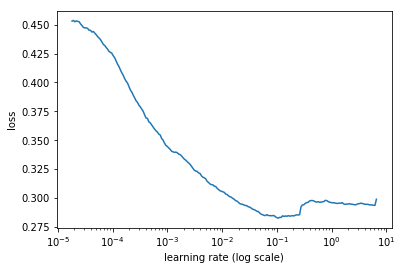

In [61]:
m.sched.plot()

In [62]:
lr = 1e-3

In [63]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.270688   0.253164  
    1      0.259848   0.251528                               
    2      0.261312   0.250361                               
    3      0.25589    0.249193                               



[array([0.24919])]

In [64]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.25713    0.249542  
    1      0.253653   0.248271                               
    2      0.25243    0.247834                               
    3      0.253279   0.247461                               



[array([0.24746])]

In [65]:
m.fit(lr, 2, cycle_len=2)

epoch      trn_loss   val_loss                               
    0      0.253666   0.247406  
    1      0.250611   0.247172                               
    2      0.252003   0.247591                               
    3      0.247068   0.246538                               



[array([0.24654])]

In [66]:
m.fit(lr, 5, wds=1e-7, cycle_len=3, best_save_name="best_home_default1")

epoch      trn_loss   val_loss                               
    0      0.250472   0.247309  
    1      0.246302   0.246642                               
    2      0.243831   0.246405                               
    3      0.245062   0.246938                               
    4      0.246787   0.246543                               
    5      0.246192   0.246451                               
    6      0.246304   0.246762                               
    7      0.24489    0.246524                               
    8      0.242401   0.246465                               
    9      0.244605   0.248182                               
    10     0.243639   0.246976                               
    11     0.240037   0.246715                               
    12     0.242655   0.247298                               
    13     0.24212    0.247233                               
    14     0.237109   0.246996                               



[array([0.247])]

In [67]:
m.load(name="best_home_default1")

In [68]:
m.fit(lr/10, 2, cycle_len=2, wds=1e-7, best_save_name="best_home_default2")

epoch      trn_loss   val_loss                               
    0      0.248324   0.246439  
    1      0.245918   0.246365                               
    2      0.245296   0.246307                               
    3      0.24476    0.246377                               



[array([0.24638])]

In [69]:
m.load(name="best_home_default2")

In [70]:
pred_test=m.predict(True)

In [71]:
pred_test = np.exp(pred_test)

In [72]:
pred_test[:,0]

array([0.97448, 0.8418 , 0.94074, 0.89931, 0.80659, 0.96739, 0.97404, 0.96621, 0.98438, 0.85234, 0.97342,
       0.951  , 0.88783, 0.96161, 0.96416, 0.86352, 0.94732, 0.97208, 0.83933, 0.95161, ..., 0.91386,
       0.91526, 0.98401, 0.97078, 0.98756, 0.93182, 0.89695, 0.98905, 0.91819, 0.96647, 0.951  , 0.93   ,
       0.9666 , 0.91358, 0.96653, 0.95205, 0.91822, 0.97493, 0.93358, 0.87553], dtype=float32)

(array([    1.,     2.,    13.,   112.,   402.,   947.,  1877.,  4358., 12010., 29022.]),
 array([0.29673, 0.36706, 0.43738, 0.50771, 0.57804, 0.64836, 0.71869, 0.78902, 0.85935, 0.92967, 1.     ]),
 <a list of 10 Patch objects>)

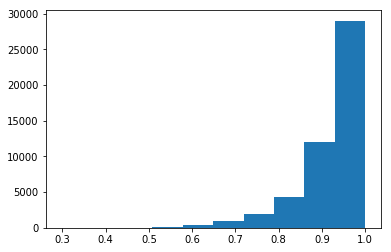

In [73]:
matplotlib.pyplot.hist(pred_test[:,0])

In [74]:
application_test['TARGET']=pred_test[:,1]

In [116]:
csv_fn=f'{PATH}/tmp/sub7.csv'

In [117]:
application_test['SK_ID_CURR'] = application_test['SK_ID_CURR'].astype(int)

In [118]:
application_test[['SK_ID_CURR','TARGET']].to_csv(csv_fn, index=False)

In [ ]:
FileLink(csv_fn)

/home/cheeseblubber/workspace/competition/home-default-credit/data/tmp/sub7.csv